In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
# This import registers the 3D projection, but is otherwise unused.
from matplotlib import cm
import cv2
import math

In [36]:
%matplotlib inline

In [66]:
#bi1_mean and scale_bi's are only hyperparameters
scale_bi1 = -1/2
scale_bi2 = 3/4

bi1_mean = 0.2
bi2_mean = bi1_mean * 2
# - in the scale for positive value
mono_mean = (1 + bi1_mean * np.sqrt(36 + 10 * np.log(-scale_bi1 / scale_bi2))) / 10
# 3 sigma rule for bi1 and mono
bi1_sigma = bi1_mean / 3
bi2_sigma = bi1_sigma * (3/2)
mono_sigma = mono_mean / 3

In [56]:
def load_events(path_to_events):
    event_list = pd.read_csv(path_to_events, delim_whitespace=True, header=None,
                          names=['t', 'x', 'y', 'p'],
                          dtype={'t': np.float64, 'x': np.int16, 'y': np.int16, 'p': np.int8},
                          engine='c', nrows=None, memory_map=True)
    # no polarity needed
    event_list = event_list.drop(columns=['p'])
    event_list = event_list.to_records(index=False)

    # First row: time, x, y
    time_start = event_list[0][0]
    time_end = event_list[len(event_list)-1][0]

    print("Loaded {:.2f}M events.".format(len(event_list) / 1e6))
    print("Time between: {} and {}.".format(time_start, time_end))
    
    return event_list

In [57]:
path_to_events = '../slider_far/events.txt'
event_list = load_events(path_to_events)

Loaded 3.44M events.
Time between: 0.0 and 6.399144.


In [181]:
tau = np.pi * 2  # apparently there is a name for 2*pi

def spatial_gabor_filter_even(x, y, sigma, theta, f0x, f0y):
    theta = -theta
    theta -= np.pi / 4
    
    x_hat = np.cos(theta) * x + np.sin(theta) * y
    y_hat = -np.sin(theta) * x + np.cos(theta) * y

    gabor_first = np.exp(-1 * ((x_hat)**2 + (y_hat)**2) * (2 * np.pi**2) / sigma**2)
    gabor_second = np.cos(tau * (f0x * x_hat + f0y * y_hat))
    gabor_even = (tau / sigma**2) * gabor_first * gabor_second

    return gabor_even


def spatial_gabor_filter_odd(x, y, sigma, theta, f0x, f0y):
    # rotation and appending is needed for x, y axes
    theta = -theta
    theta -= np.pi / 4
    
    x_hat = np.cos(theta) * x + np.sin(theta) * y
    y_hat = -np.sin(theta) * x + np.cos(theta) * y

    gabor_first = np.exp(-1 * (x_hat**2 + y_hat**2) * (2 * np.pi**2 / sigma**2))
    gabor_second = np.sin(tau * (f0x * x_hat + f0y * y_hat))
    gabor_odd = (tau / sigma**2) * gabor_first * gabor_second

    return gabor_odd

In [182]:
# def temporal_filter(t, mu, sigma):
#     temp_filter = np.exp(-(t - mu)**2 / (2 * sigma**2))
    
#     return temp_filter

In [183]:
class TemporalFilter:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.exponent_multiplier = -1 / (2 * sigma**2)
        
    def get(self, time):
        time_diff = (self.mu - time)**2
        exponent_value = np.exp(time_diff * self.exponent_multiplier)

        return exponent_value

In [184]:
def generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0y):
    spatial_even_filters = list()
    spatial_odd_filters = list()

    filter_range = np.arange(-filter_apothem, filter_apothem+1)  #  may be optimized (no minus part) by direction / sign change
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    filter_width_range, filter_height_range = np.meshgrid(filter_range, filter_range, indexing="xy")

    for i in range(filter_amount):
        angle = tau * i / filter_amount
        gabor_even = spatial_gabor_filter_even(filter_width_range, filter_height_range, spatial_sigma, angle, f0x, f0y)
        gabor_odd = spatial_gabor_filter_odd(filter_width_range, filter_height_range, spatial_sigma, angle, f0x, f0y)

        spatial_even_filters.append(gabor_even)
        spatial_odd_filters.append(gabor_odd)
    
    return spatial_even_filters, spatial_odd_filters

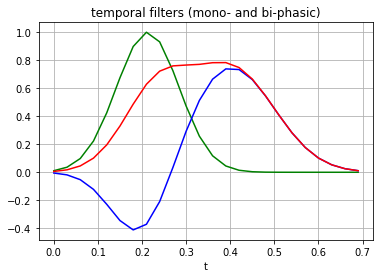

In [185]:
t = np.arange(0.0, 0.7, 0.03)
temporal_mono_filter = TemporalFilter(mono_mean, mono_sigma)
temporal_bi1_filter = TemporalFilter(bi1_mean, bi1_sigma)
temporal_bi2_filter = TemporalFilter(bi2_mean, bi2_sigma)
t_mono = temporal_mono_filter.get(t)
t_bi = scale_bi1 * temporal_bi1_filter.get(t)
t_bi += scale_bi2 * temporal_bi2_filter.get(t)

fig2, ax1 = plt.subplots()
val_max = np.max([np.max(np.abs(t_mono)), np.max(np.abs(t_bi))])
ax1.plot(t, t_mono / val_max, "g-")
ax1.plot(t, t_bi / val_max, "b-")
ax1.plot(t, (t_mono + t_bi) / val_max, "r-")
ax1.set_title("temporal filters (mono- and bi-phasic)")
ax1.set_xlabel("t")
plt.savefig("temporal_filters_mono_bi.png")
plt.grid()
plt.show()

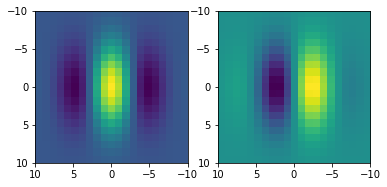

In [204]:
scale_factor = 1
f0x = 0.057 / scale_factor  # units: cycles/pix ?
f0y = f0x

filter_amount = 4
filter_apothem = 10 * scale_factor
spatial_sigma = 25 * scale_factor

filter_size = filter_apothem * 2 + 1

spatial_even_filters, spatial_odd_filters = \
    generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0y)

G_even = spatial_even_filters[0]
G_odd = spatial_odd_filters[0]
fig = plt.figure()
axis_extend = [filter_apothem, -filter_apothem, filter_apothem, -filter_apothem]
plt.subplot(1, 2, 1), plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.imshow(G_odd, extent=axis_extend)
plt.savefig("spatial_filters_1.png")

# Note: Shows neuron's response, not the filter itself.

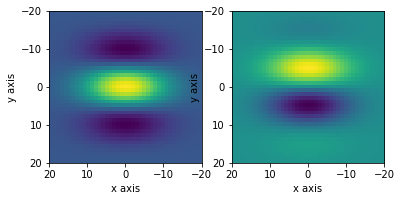

In [197]:
G_even = spatial_even_filters[1]
G_odd = spatial_odd_filters[1]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis"),
plt.imshow(G_odd, extent=axis_extend)
plt.savefig("spatial_filters_2.png")

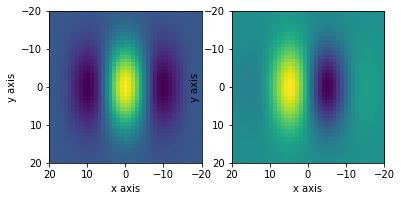

In [198]:
G_even = spatial_even_filters[2]
G_odd = spatial_odd_filters[2]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_odd, extent=axis_extend)
plt.savefig("spatial_filters_3.png")

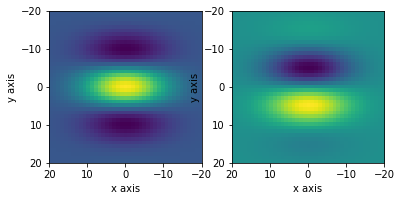

In [199]:
G_even = spatial_even_filters[3]
G_odd = spatial_odd_filters[3]
fig = plt.figure()
plt.subplot(1, 2, 1), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_even, extent=axis_extend)
plt.subplot(1, 2, 2), plt.xlabel("x axis"), plt.ylabel("y axis")
plt.imshow(G_odd, extent=axis_extend)
plt.savefig("spatial_filters_4.png")

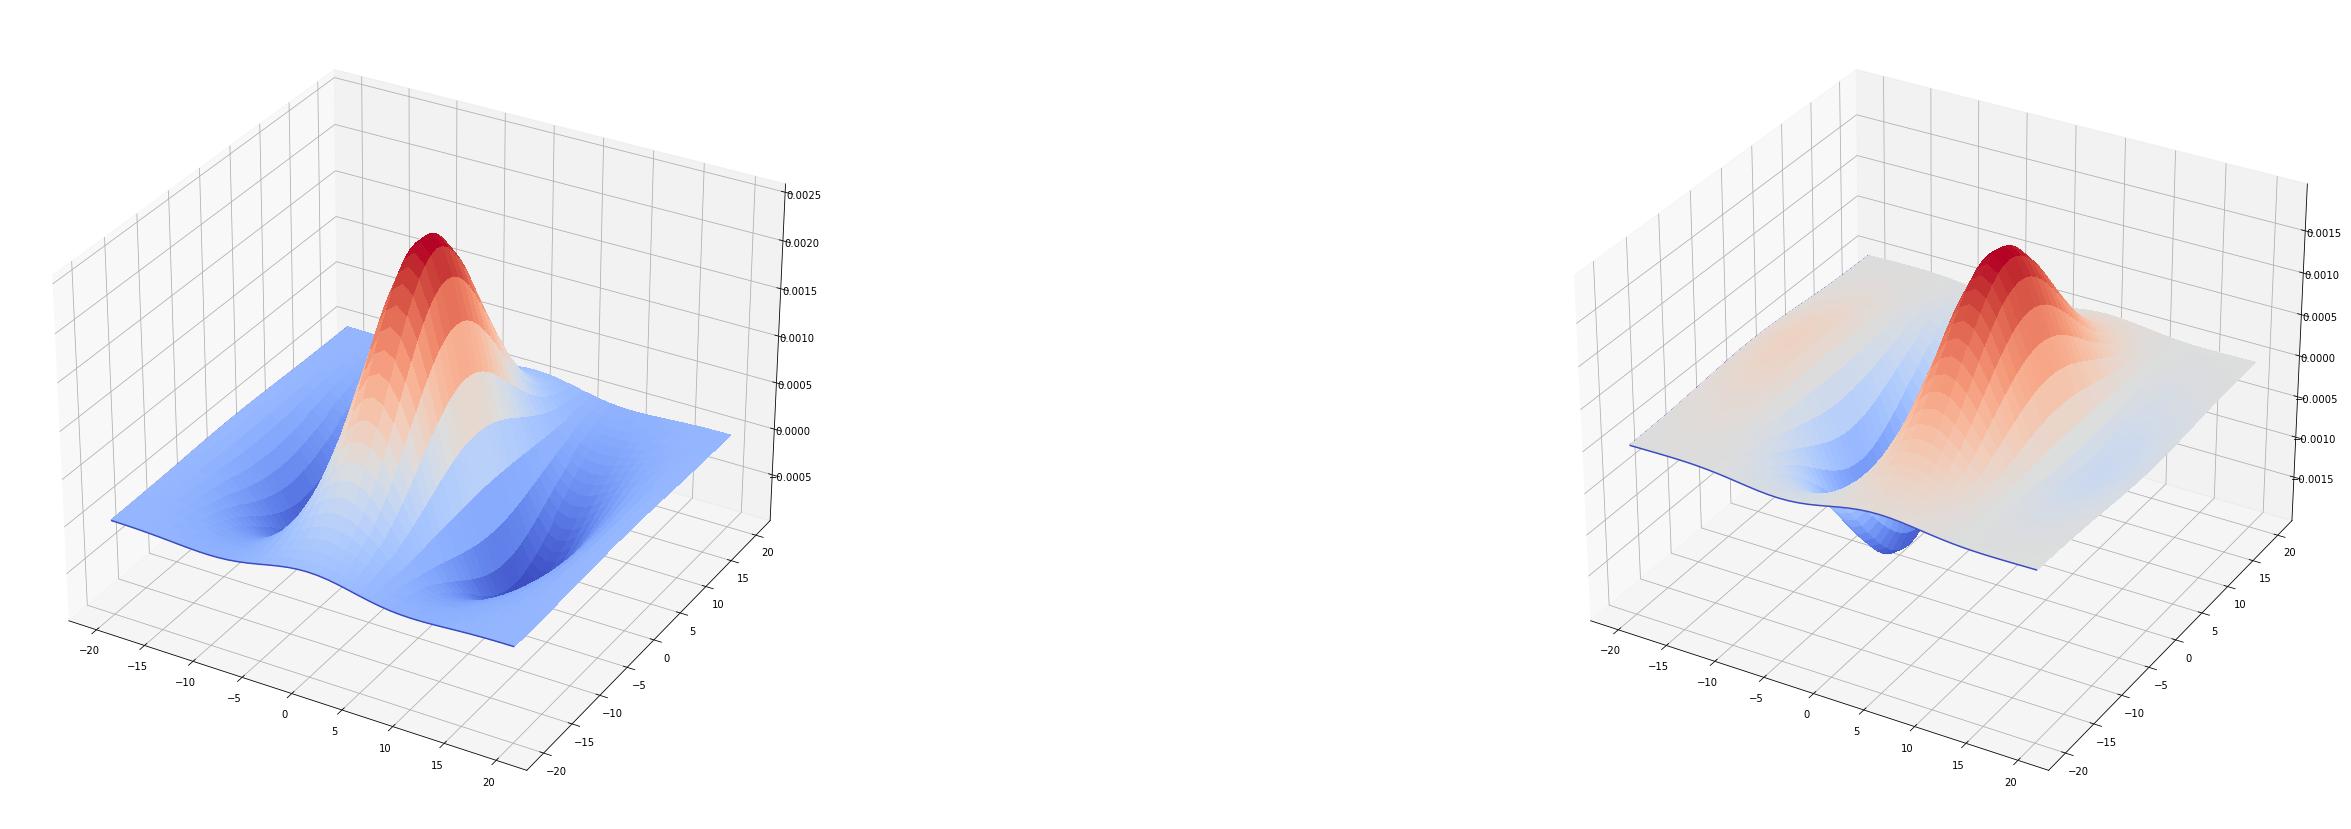

In [200]:
fig = plt.figure(figsize=(50, 15))

val_range = np.arange(-filter_apothem, filter_apothem+1)
X, Y = np.meshgrid(val_range, val_range)

show_filters = 1
nrows = 1

for filter_ in range(show_filters):
    ev_filter = spatial_even_filters[filter_]
    odd_filter = spatial_odd_filters[filter_]
    ax = fig.add_subplot(nrows, 2 * math.ceil(show_filters / nrows), filter_ * 2 + 1, projection="3d")    
    ax.plot_surface(X, Y, ev_filter, rstride=1, cstride=1, cmap=cm.coolwarm, \
                    linewidth=0, antialiased=False)
    # ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
    ax.contour(X, Y, ev_filter, zdir="z", cmap=cm.coolwarm)
    ax.contour(X, Y, ev_filter, zdir="x", cmap=cm.coolwarm)
    ax.contour(X, Y, ev_filter, zdir="y", cmap=cm.coolwarm)
    
    ax = fig.add_subplot(nrows, 2 * math.ceil(show_filters / nrows), filter_ * 2 + 2, projection="3d")    
    ax.plot_surface(X, Y, odd_filter, rstride=1, cstride=1, cmap=cm.coolwarm, \
                    linewidth=0, antialiased=False)
    # ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
    ax.contour(X, Y, odd_filter, zdir="z", cmap=cm.coolwarm)
    ax.contour(X, Y, odd_filter, zdir="x", cmap=cm.coolwarm)
    ax.contour(X, Y, odd_filter, zdir="y", cmap=cm.coolwarm)
    
    # cb = fig.colorbar(p, shrink=0.5)
#     ax.set_title(" filter bank " + str(i) + "/8 pi")
#     ax.set_zlabel("Z", fontdict={"size": 15, "color": "red"})
#     ax.set_ylabel("Y", fontdict={"size": 15, "color": "red"})
#     ax.set_xlabel("X", fontdict={"size": 15, "color": "red"})

plt.savefig("spatial_3d.png")
plt.show()

In [191]:
space_time_filters = []
filters_to_pi = filter_amount // 2
for i in range(filters_to_pi):
    G_even = spatial_even_filters[i]
    G_odd = spatial_odd_filters[i]
    space_time_kernel = G_even[:, :, None] * t_bi + G_odd[:, :, None] * t_mono
    space_time_filters.append(space_time_kernel)

<Figure size 432x288 with 0 Axes>

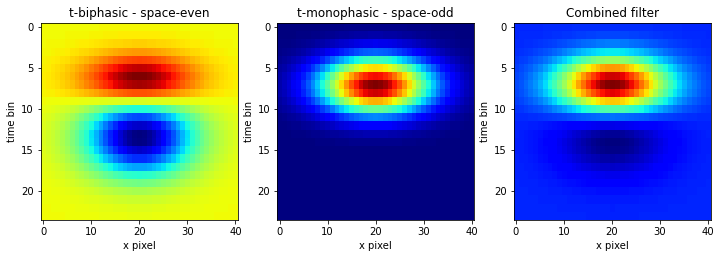

In [140]:
# Plot an x-t slice of each component of the space-time filter
# Fig 3 in the 2014 paper
slice_idx = filter_apothem  # index of the central y-slice, transposed

fig = plt.figure()
plt.figure(figsize=(12,12))

num_bins_t = len(t_mono)

filter_index = 0
space_time_kernel_even = spatial_even_filters[filter_index][:, :, None] * t_bi
space_time_kernel_odd = spatial_odd_filters[filter_index][:, :, None] * t_mono
space_time_kernel_sum = space_time_kernel_even + space_time_kernel_odd

slice_idx = 15
sliced_st_even = space_time_kernel_even[:, slice_idx, :]
sliced_st_odd = space_time_kernel_odd[:, slice_idx, :]
sliced_st_sum = space_time_kernel_sum[:, slice_idx, :]


plt.subplot(1, 3, 1)

set_aspect_val = filter_size / num_bins_t

plt.imshow(np.transpose(sliced_st_even), cmap='jet_r')
#plt.gca().invert_yaxis()
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-biphasic - space-even")
plt.savefig("filters1.png")
plt.subplot(1, 3, 2),
plt.imshow(np.transpose(sliced_st_odd), cmap='jet_r')
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-monophasic - space-odd")
plt.savefig("filters2.png")
plt.subplot(1, 3, 3),
plt.imshow(np.transpose(sliced_st_sum), cmap='jet_r')
plt.gca().set_aspect(set_aspect_val)
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("Combined filter")
plt.savefig("filters3.png")


<Figure size 432x288 with 0 Axes>

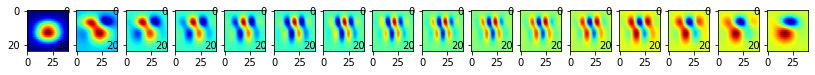

In [84]:
# Show filters
fig = plt.figure()
plt.figure(figsize=(14,14))
num_filters = len(space_time_filters)
# print(filters[0][:,5,:])
for i in range(num_filters):
    plt.subplot(1,num_filters, i+1),
    plt.imshow(np.transpose(space_time_filters[i][:,slice_idx,:]), cmap='jet_r')
    #plt.gca().invert_yaxis()
    plt.gca().set_aspect( (filter_size / num_bins_t) )

In [85]:
plt.savefig("spacetime.png")

<Figure size 432x288 with 0 Axes>

In [86]:
# Compute response of the filter to a given input. See description in LNAI8774 2014
# Bio-inspired optic flow from event-based neuromorphic sensor input, Section 3

In [87]:
# Temporal filters become 0 when t_diff > 0.07
# So we can get a period that uses such
t_diff = 0.7

t_start = event_list[0][0]
t_end = t_start + t_diff


start_ind = 0 # replace with searchsorted left if not 0
stop_ind = np.searchsorted(event_list['t'], t_end, "left")

event_subset = event_list[start_ind:stop_ind]
print("Number of events: {}".format(stop_ind))
print("Time interval: {} : {}".format(t_start, t_end))

Number of events: 263749
Time interval: 0.0 : 0.7


In [88]:
# First, try the synchronous solution: convert the events to a 3D voxel grid by voting:
# each events fills in some part of the 3D grid, according to a Gaussian weights in space and time

# DAVIS camera pixel resolution
sensor_width = 240
sensor_height = 180

In [89]:
filter_amount = 4
spatial_even_filters, spatial_odd_filters = \
    generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0x)

In [90]:
def get_filtered_image(event_subset, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, filter_apothem, f0x,
                       temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       spatial_even_filters, spatial_odd_filters
                      ):
       
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    stop_index = len(event_subset)
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((2, pixels_y, pixels_x), dtype=np.float64)
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t

        # Start with even_filter's component, biphasic. Plus 0 is even
        image_phasic[0, y, x] += scale_biphasic1 * temporal_bi1_filter.get(t_diff) + \
            scale_biphasic2 * temporal_bi2_filter.get(t_diff)
        image_phasic[1, y, x] += temporal_mono_filter.get(t_diff)
    
    
    filtered_image = np.zeros((filter_amount, pixels_y, pixels_x), dtype=np.float64)

    for i in range(filter_amount):
        filtered_image[i] = cv2.filter2D(image_phasic[0], -1, spatial_even_filters[i], borderType=cv2.BORDER_ISOLATED)
        filtered_image[i] += cv2.filter2D(image_phasic[1], -1, spatial_odd_filters[i], borderType=cv2.BORDER_ISOLATED)        
        
    return filtered_image

In [91]:
%%time
filtered_image = get_filtered_image(event_subset, t_end,
                              0, 0, sensor_width, sensor_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

Wall time: 3.79 s


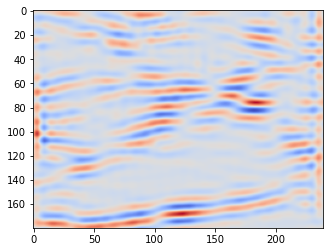

In [92]:
res = np.sum(filtered_image, axis=0)
plt.imshow(res, cmap=cm.coolwarm)
plt.savefig("res.png")

<Figure size 432x288 with 0 Axes>

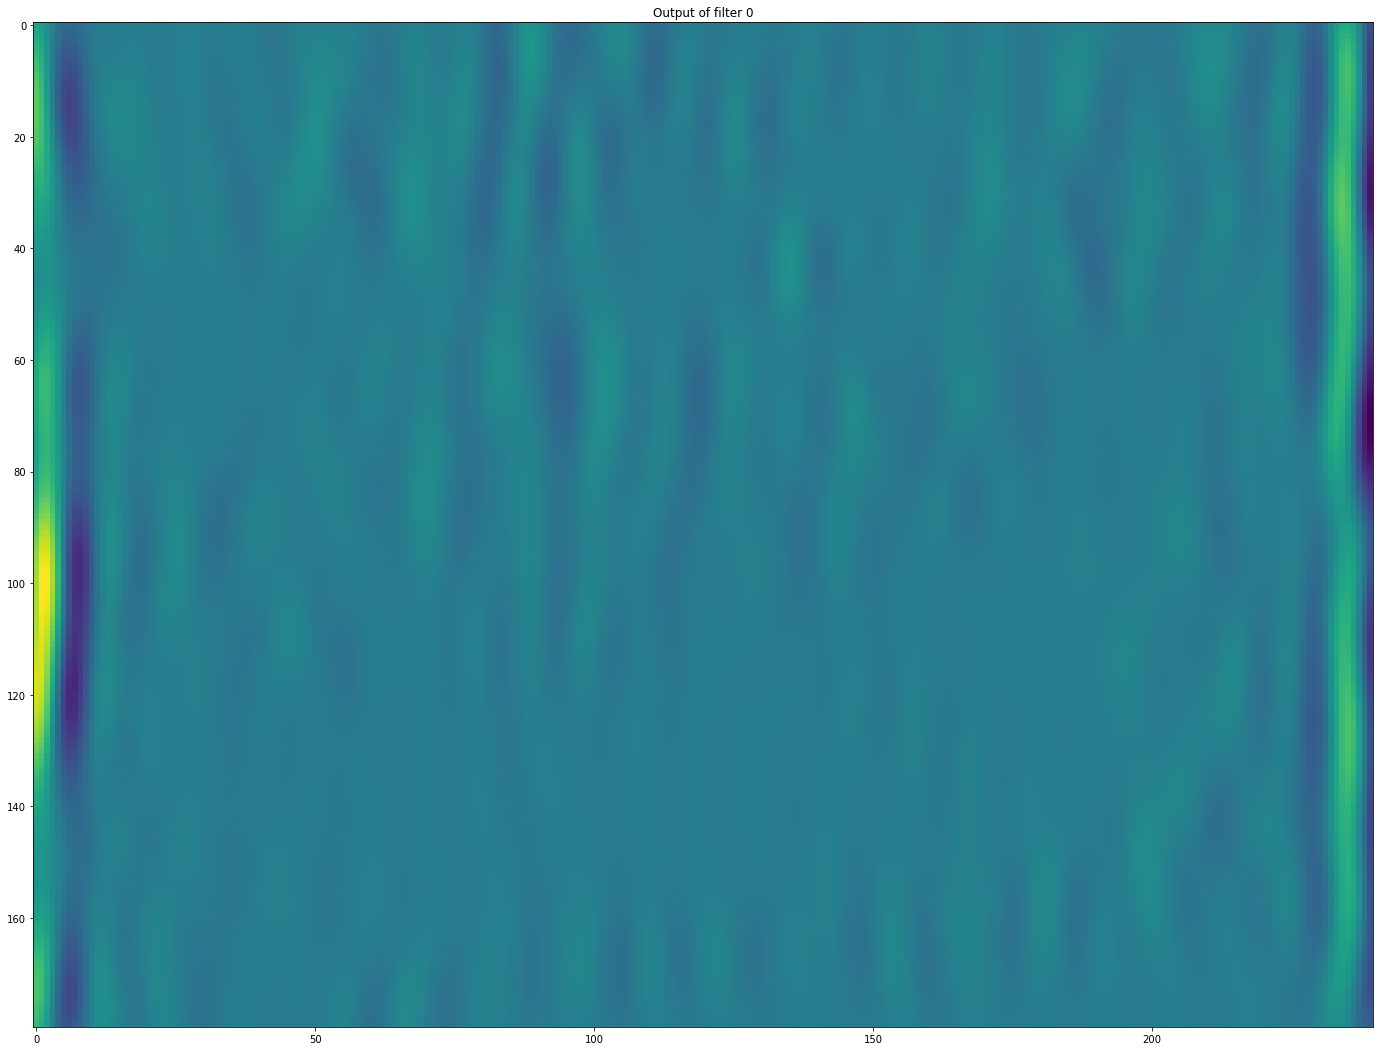

In [93]:
# Visualize results
fig = plt.figure()
plt.figure(figsize=(24, 24))

filters_to_show = filter_amount // 4

for i in range(filters_to_show):
    plt.subplot(1, filters_to_show, i+1)
    plt.imshow(filtered_image[i])
    plt.title("Output of filter " + str(i))

In [94]:
def filter_vectors(filtered_image, filter_amount):
    pixels_y, pixels_x = filtered_image.shape[1:]
    u = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    v = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    for k in range(filter_amount):
        # there is no minus in sin, which I think is correct.
        # this is due to -theta in filter.
        u = u + np.cos(tau * k / filter_amount) * filtered_image[k]
        v = v + np.sin(tau * k / filter_amount) * filtered_image[k]
    return u, v

In [95]:
u, v = filter_vectors(filtered_image, filter_amount)

In [96]:
def quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop):
    
    u_subspace = u[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]
    v_subspace = v[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]

    u_subspace = u_subspace[::-1]
    v_subspace = v_subspace[::-1]
    
    x_subspace = np.arange(x_subspace_start, x_subspace_stop)
    y_subspace = np.arange(y_subspace_start, y_subspace_stop)
    x_subspace, y_subspace = np.meshgrid(x_subspace, y_subspace)
    
    fig = plt.figure(figsize=(24, 18))
    plt.quiver(u_subspace, v_subspace, color="r")

In [97]:
# quiver_show_subset(u, v, 0, sensor_width, 0, sensor_height)
# plt.savefig("whole_image.png")

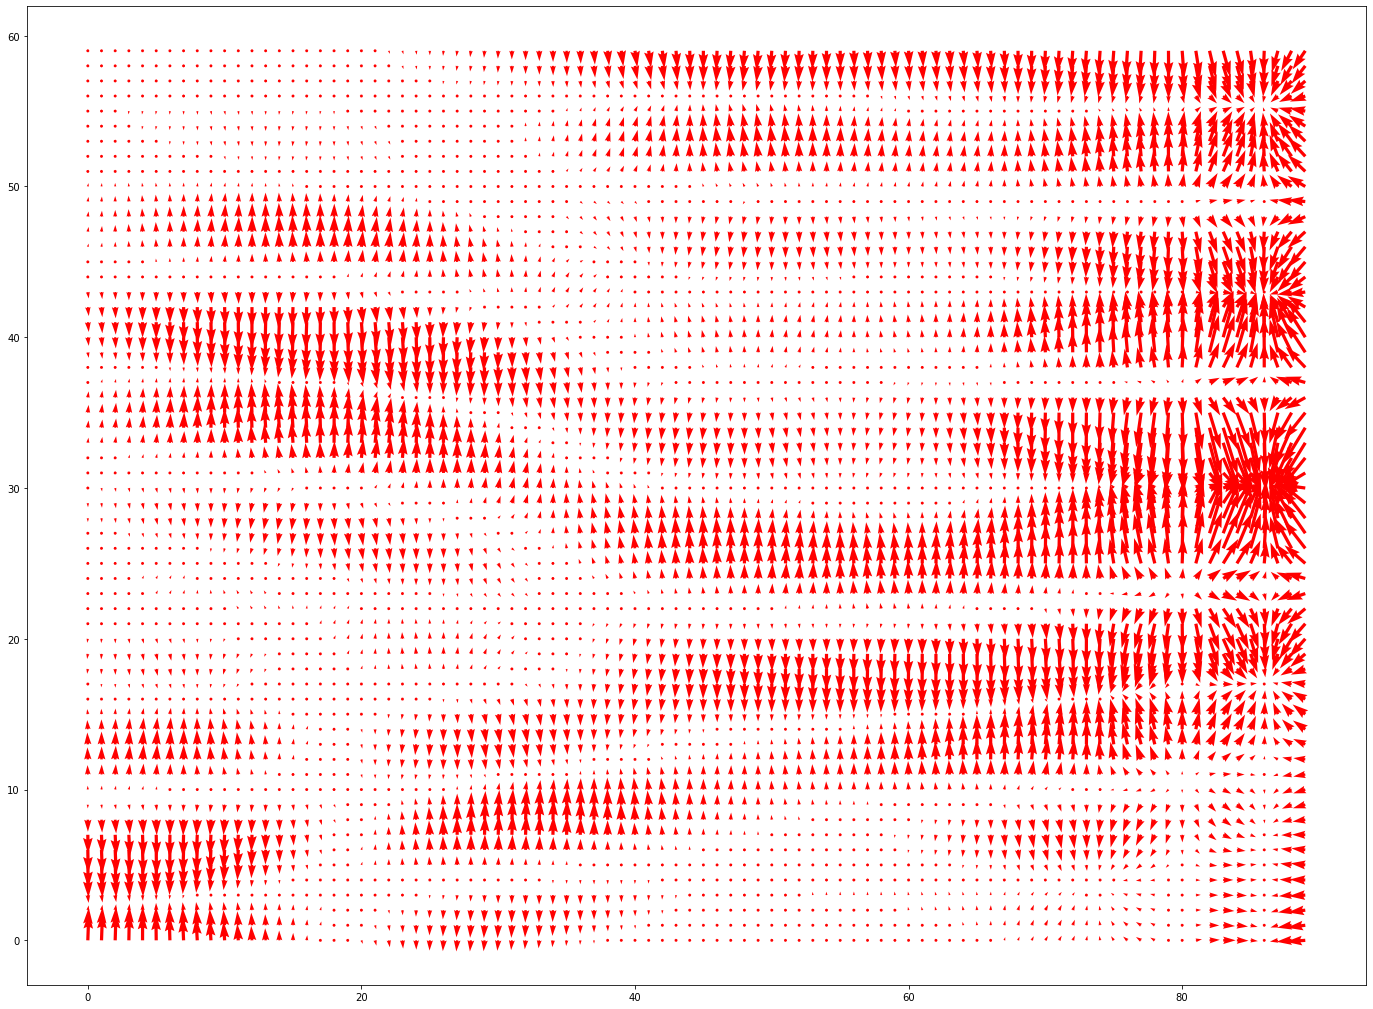

In [98]:
x_subspace_start = 150
x_subspace_stop = 240
y_subspace_start = 0
y_subspace_stop = 60

quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image.png")

In [99]:
def normalize(u, v):
    beta_response = 1
    alpha_p = 0.1
    alpha_q = 0.002
    sigma_response = 3.6

    center = math.ceil(sigma_response * 3)
    size = center * 2 + 1

    filter_gaussian = cv2.getGaussianKernel(size, sigma_response)

    def relu(x):
        return x * (x > 0)

    uv_response = np.sqrt(u**2 + v**2)

    relu_response = relu(uv_response)
    gaussian_response = cv2.filter2D(relu_response, -1, filter_gaussian)
    normalized_response = beta_response * uv_response / (alpha_p + uv_response + relu(gaussian_response / alpha_q))

    ratio = normalized_response / uv_response
    u_normalized = ratio * u
    v_normalized = ratio * v

    return u_normalized, v_normalized

In [100]:
u_normalized, v_normalized = normalize(u, v)

In [101]:
# quiver_show_subset(u, v, 0, sensor_width, 0, sensor_height)

In [102]:
# quiver_show_subset(u_normalized, v_normalized, 0, sensor_width, 0, sensor_height)
# plt.savefig("whole_image_normalized.png")

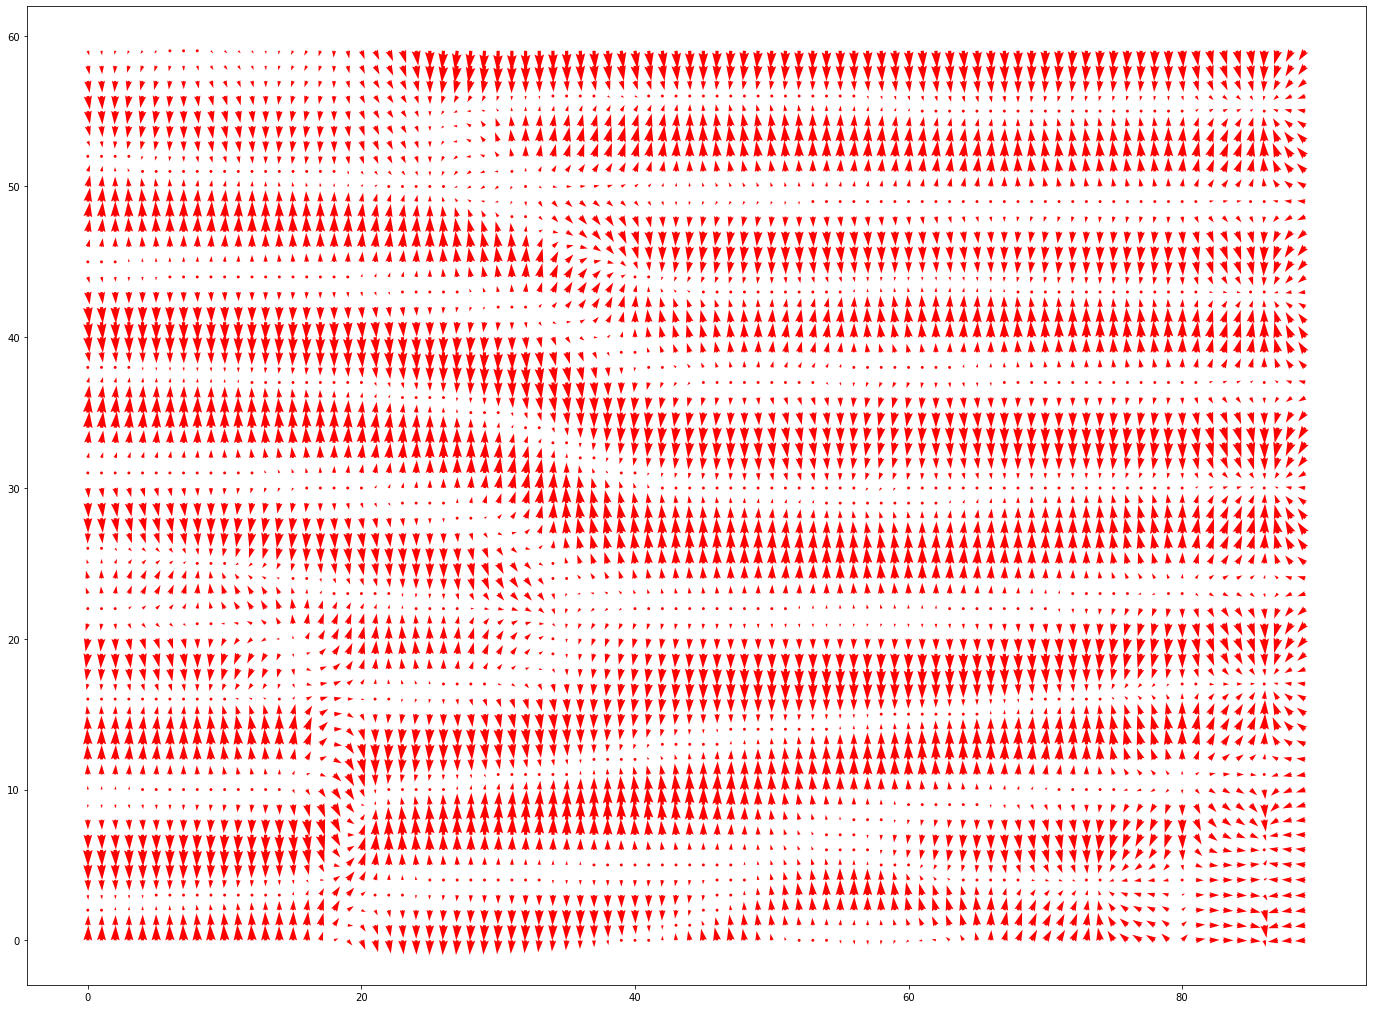

In [103]:
quiver_show_subset(u_normalized, v_normalized, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
# plt.savefig("partial_image_normalized.png")

In [104]:
t_start = 0.7
t_amount = 14
t_iter = 0.1
t_interval = 0.7

t_start_range = np.arange(t_amount) * t_iter + t_start
t_end_range = t_start_range + t_interval

start_inds = np.searchsorted(event_list['t'], t_start_range, "left")
stop_inds = np.searchsorted(event_list['t'], t_end_range, "right")

filtered_images = np.empty((t_amount, filter_amount, sensor_height, sensor_width))

for index in range(t_amount):
    event_subset_time = event_list[start_inds[index]:stop_inds[index]]
    filtered_images[index] = get_filtered_image(event_subset_time, t_end_range[index],
                              0, 0, sensor_width, sensor_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

KeyboardInterrupt: 

In [ ]:
# filter_response_sum = np.sum(filtered_images, axis=0)
# u_total, v_total = filter_vectors(filter_response_sum, filter_amount)

u_list = np.empty((t_amount, sensor_height, sensor_width))
v_list = np.empty((t_amount, sensor_height, sensor_width))
for i in range(t_amount):
    u_total, v_total = filter_vectors(filtered_images[i], filter_amount)
    u_list[i] = u_total
    v_list[i] = v_total

In [ ]:
print(np.max(u_list[i]))
print(np.max(filtered_images[index]))

In [ ]:
u_total = np.sum(u_list, axis=0)
v_total = np.sum(v_list, axis=0)

quiver_show_subset(u_total, v_total, 0, sensor_width, 0, sensor_height)
plt.savefig("whole_image_over_time.png")

In [ ]:
quiver_show_subset(u_list[0], v_list[0], x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_over_time.png")

In [ ]:
quiver_show_subset(u_total, v_total, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_over_time.png")

In [ ]:
u_normalized, v_normalized = normalize(u, v)

quiver_show_subset(u_normalized, v_normalized, 0, sensor_width, 0, sensor_height)
plt.savefig("whole_image_over_time_normalized.png")

In [ ]:
quiver_show_subset(u_normalized, v_normalized, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_over_time_normalized.png")

In [ ]:
# # Temporal filters become 0 when t_diff > 0.07
# # So we can get a period that uses such
# t_diff = 0.7

# t_start = event_list[0][0]
# t_end = t_start + t_diff


# start_ind = 0 # replace with searchsorted left if not 0
# stop_ind = np.searchsorted(event_list['t'], t_end, "left")

# event_subset = event_list[start_ind:stop_ind]
# print("Number of events: {}".format(stop_ind))
# print("Time interval: {} : {}".format(t_start, t_end))

# filter_amount = 4
# spatial_even_filters, spatial_odd_filters = \
#     generate_spatial_filters(filter_amount, filter_apothem, spatial_sigma, f0x, f0x)

# grid_vox = get_filtered_image_optimized(event_subset, t_end,
#                               0, 0, band_width, band_height,
#                               filter_amount, filter_apothem, f0x,
#                               temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
#                               scale_bi1, scale_bi2,
#                               spatial_even_filters, spatial_odd_filters)

# u_small_filters = np.zeros((band_height, band_width), dtype=np.float32)
# v_small_filters = np.zeros((band_height, band_width), dtype=np.float32)
# for k in range(filter_amount):
#     # there is no minus in sin, which I think is correct.
#     # this is due to -theta in filter.
#     u_small_filters = u_small_filters + np.cos(tau * k / filter_amount) * grid_vox[:,:,k]
#     v_small_filters = v_small_filters + np.sin(tau * k / filter_amount) * grid_vox[:,:,k]
    
# quiver_show_subset(u_small_filters, v_small_filters, 0, sensor_width, 0, sensor_height)
# plt.savefig("whole_image_small.png")

# quiver_show_subset(u_small_filters, v_small_filters, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
# plt.savefig("partial_image_small.png")

# u_small_norm, v_small_norm = normalize(u_small_filters, v_small_filters)
# quiver_show_subset(u_small_norm, v_small_norm, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
# plt.savefig("partial_image_small_norm.png")

In [ ]:
# diff_u = u - u_small_norm
# diff_v = v - v_small_norm

# quiver_show_subset(diff_u, diff_v, 0, band_width, 0, band_height)
# plt.savefig("whole_image_small_diff.png")

# quiver_show_subset(diff_u, diff_v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
# plt.savefig("partial_image_small_diff.png")

In [ ]:
# print(np.max(np.abs(diff_u)), np.max(np.abs(diff_v)))
# print(np.sum(np.abs(diff_u) > 10))
# print(np.sum(np.abs(diff_v) > 10))
# print(np.product(diff_u.shape))

In [ ]:
# diff_u_norm = u_normalized - u_small_norm
# diff_v_norm = v_normalized - v_small_norm

# quiver_show_subset(diff_u_norm, diff_v_norm, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
# plt.savefig("partial_image_small_norm_diff.png")

In [ ]:
def dilate_time(event_list, dilation_time, desired_t_start=0):
    events = np.copy(event_list)

    t_start = events[0][0] 
    t_end = events[-1][0]
    t_diff = t_end - t_start

    dilation_scale = dilation_time / t_diff
    
    events['t'] = (events['t'] +- t_start) * dilation_scale + desired_t_start
    return events

In [ ]:
path_to_events = '../slider_far/events_chunk.txt'
second_event_list = load_events(path_to_events)

dilation_time = 0.7
second_event_dilated = dilate_time(second_event_list, dilation_time)
second_image_output = get_filtered_image(second_event_dilated, dilation_time,
                              0, 0, sensor_width, sensor_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

u_second, v_second = filter_vectors(second_image_output, filter_amount)

quiver_show_subset(u_second, v_second, 0, sensor_width, 0, sensor_height)
quiver_show_subset(u_second, v_second, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)

In [ ]:
t_start = 0.7
t_amount = 14
t_iter = 0.1
t_interval = 0.7


t_start_range = np.arange(t_amount) * t_iter + t_start
t_end_range = t_start_range + t_interval

second_event_dilated_range = dilate_time(second_event_list, t_end_range[-1] - t_start, t_start)

start_inds = np.searchsorted(second_event_dilated_range['t'], t_start_range, "left")
stop_inds = np.searchsorted(second_event_dilated_range['t'], t_end_range, "right")

filtered_images = np.empty((t_amount, filter_amount, sensor_height, sensor_width))

for index in range(t_amount):
    event_subset_time = second_event_dilated_range[start_inds[index]:stop_inds[index]]
    filtered_images[index] = get_filtered_image(event_subset_time, t_end_range[index],
                              0, 0, sensor_width, sensor_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

u_list = np.empty((t_amount, sensor_height, sensor_width))
v_list = np.empty((t_amount, sensor_height, sensor_width))
for i in range(t_amount):
    u_total, v_total = filter_vectors(filtered_images[i], filter_amount)
    u_list[i] = u_total
    v_list[i] = v_total

u_total = np.sum(u_list, axis=0)
v_total = np.sum(v_list, axis=0)                                                

quiver_show_subset(u_total, v_total, 0, sensor_width, 0, sensor_height)
quiver_show_subset(u_total, v_total, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)

In [ ]:
print(np.sum(np.abs(u_total[20:160,20:220])), np.sum(np.abs(v_total[20:160,20:220])))

In [ ]:
t_start = 3.5
t_amount = 30
t_iter = 0.1
t_interval = 0.7

t_start_range = np.arange(t_amount) * t_iter + t_start
t_end_range = t_start_range + t_interval

start_inds = np.searchsorted(event_list['t'], t_start_range, "left")
stop_inds = np.searchsorted(event_list['t'], t_end_range, "right")

filtered_images = np.empty((t_amount, filter_amount, sensor_height, sensor_width))

for index in range(t_amount):
    event_subset_time = event_list[start_inds[index]:stop_inds[index]]
    filtered_images[index] = get_filtered_image(event_subset_time, t_end_range[index],
                              0, 0, sensor_width, sensor_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)
    
# filter_response_sum = np.sum(filtered_images, axis=0)
# u_total, v_total = filter_vectors(filter_response_sum, filter_amount)

u_list = np.empty((t_amount, sensor_height, sensor_width))
v_list = np.empty((t_amount, sensor_height, sensor_width))
for i in range(t_amount):
    u_total, v_total = filter_vectors(filtered_images[i], filter_amount)
    u_list[i] = u_total
    v_list[i] = v_total

u_total = np.sum(u_list, axis=0)
v_total = np.sum(v_list, axis=0)

quiver_show_subset(u_total, v_total, 0, sensor_width, 0, sensor_height)
plt.savefig("whole_image_over_time.png")
quiver_show_subset(u_total, v_total, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_over_time.png")

In [ ]:
u_norm_list = np.empty((t_amount, sensor_height, sensor_width))
v_norm_list = np.empty((t_amount, sensor_height, sensor_width))
for i in range(t_amount):
    u_norm, v_norm = normalize(u_list[i], v_list[i])
    u_norm_list[i] = u_norm
    v_norm_list[i] = v_norm
    
u_norm_total = np.sum(u_norm_list, axis=0)
v_norm_total = np.sum(v_norm_list, axis=0)

quiver_show_subset(u_norm_total, v_norm_total, 0, sensor_width, 0, sensor_height)
plt.savefig("whole_image_over_time.png")
quiver_show_subset(u_norm_total, v_norm_total, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image_over_time.png")

In [ ]:
print(np.sum(np.abs(u_total)[20:160,20:220]), np.sum(np.abs(v_total[20:160,20:220])))

In [ ]:
print(np.sum(np.abs(u_norm_total)), np.sum(np.abs(v_norm_total)))

In [ ]:
print(np.sum(np.abs(u_norm_total[20:160,20:220])), np.sum(np.abs(v_norm_total[20:160,20:220])))

In [ ]:
quiver_show_subset(u_norm_total[20:160,20:220], np.zeros((sensor_height-40, sensor_width-40)), 0, sensor_width, 0, sensor_height)
plt.savefig("partial_image_over_time.png")

In [ ]:
# Temporal filters become 0 when t_diff > 0.07
# So we can get a period that uses such
t_diff = 0.7

t_start = 5.
t_end = t_start + t_diff


start_ind = np.searchsorted(event_list['t'], t_start, "left")
stop_ind = np.searchsorted(event_list['t'], t_end, "left")

event_subset = event_list[start_ind:stop_ind]
print("Number of events: {}".format(stop_ind - start_ind))
print("Time interval: {} : {}".format(t_start, t_end))

filtered_image = get_filtered_image(event_subset, t_end,
                              0, 0, sensor_width, sensor_height,
                              filter_amount, filter_apothem, f0x,
                              temporal_mono_filter, temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

u, v = filter_vectors(filtered_image, filter_amount)

quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig("partial_image.png")

In [ ]:
quiver_show_subset(u, v, 0, sensor_width, 0, sensor_height)


In [ ]:
print(np.sum(np.abs(u)[20:160,20:220]), np.sum(np.abs(v[20:160,20:220])))